In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [2]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", 
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", 
             "could", 
             "did", "do", "does", "doing", "down", "during", 
             "each", 
             "few", "for", "from", "further", 
             "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers",
             "herself", "him", "himself", "his", "how", "how's",
             "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself",
             "let's",
             "me", "more", "most", "my", "myself", 
             "nor", 
             "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", 
             "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", 
             "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", 
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", 
             "under", "until", "up", 
             "very", 
             "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", 
             "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", 
             "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]
print(len(stopwords))

153


In [3]:
sentences = []
labels = []

with open('tmp/bbc-text.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    line = 0
    
    for row in reader:
        if line == 0:
            line += 1
            continue
        labels.append(row[0])
        text = row[1]
        for word in stopwords:
            token = ' ' + word + ' '
            text = text.replace(token, ' ')
        
        sentences.append(text)
        line += 1

print(f'Sentences: {len(sentences)} - Labels: {len(labels)}\n')
print(sentences[0])
print(labels[0])

Sentences: 2225 - Labels: 2225

tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting togeth

In [4]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [5]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

449
120
200
120
192
120


In [6]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [10]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = label_tokenizer.texts_to_sequences(train_labels)
validation_label_seq = label_tokenizer.texts_to_sequences(validation_labels)

training_label_seq = np.array(training_label_seq)
validation_label_seq = np.array(validation_label_seq)

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(units=24, activation='relu'),
    Dense(units=6, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(train_padded, training_label_seq, epochs=30,
                    validation_data=(validation_padded, validation_label_seq))

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 [==============================] - 1s 546us/sample - loss: 1.7647 - accuracy: 0.2579 - val_loss: 1.7313 - val_accuracy: 0.4607
Epoch 2/30
1780/1780 [==============================] - 0s 201us/sample - loss: 1.6808 - accuracy: 0.4461 - val_loss: 1.6325 - val_accuracy: 0.4562
Epoch 3/30
1780/1780 [==============================] - 0s 195us/sample - loss: 1.5620 - accuracy: 0.5135 - val_loss: 1.5091 - val_accuracy: 0.4944
Epoch 4/30
1780/1780 [==============================] - 0s 193us/sample - loss: 1.4067 - accuracy: 0.6067 - val_loss: 1.3346 - val_accuracy: 0.6517
Epoch 5/30
1780/1780 [==============================] - 0s 192us/sample - loss: 1.2044 - accuracy: 0.7742 - val_loss: 1.1225 - val_accuracy: 0.8292
Epoch 6/30
1780/1780 [==============================] - 0s 183us/sample - loss: 0.9785 - accuracy: 0.8708 - val_loss: 0.9142 - val_accuracy: 0.8337
Epoch 7/30
1780/1780 [==============================] - 0s 187us/

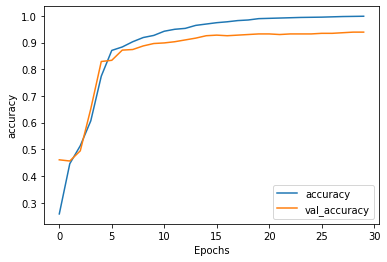

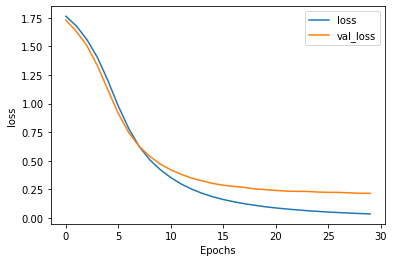

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")